# Time evolution of a Heisenberg chain

In [38]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from math import pi
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


The time evolution gate $U(\Delta t) = e^{-i H \Delta t}$, where $H = X \otimes X + Y \otimes Y + Z \otimes Z$ is the Heisenberg chain's Hamiltonian. We take $\Delta t = \frac{1}{2}$ for convenience.

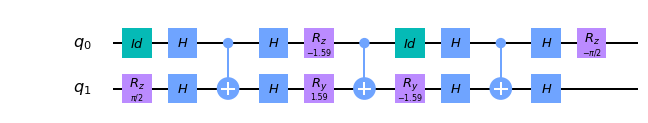

In [39]:
#dt = 0.5
dt = 0.01 # Try to minimize Trotter error

timeEv = QuantumCircuit(2,name='U_dt')

timeEv.iden(0)
timeEv.rz(pi/2,1)

timeEv.h(0)
timeEv.h(1)
timeEv.cx(0,1)
timeEv.h(0)
timeEv.h(1)

timeEv.rz(-pi/2 - 2*dt,0)
timeEv.ry(pi/2 + 2*dt,1)
timeEv.cx(0,1)
timeEv.ry(-pi/2 - 2*dt,1)
timeEv.iden(0)

timeEv.h(0)
timeEv.h(1)
timeEv.cx(0,1)
timeEv.h(0)
timeEv.h(1)

timeEv.rz(-pi/2,0)

U_dt = timeEv.to_instruction() # Convert to a gate

timeEv.draw()

We implement $U(\Delta t)$ on each consecutive pair of qubits in the register, which is initialized in state $|0\rangle^{\otimes 4}$, three times each. This simulates (up to $O(\Delta t^2)$ from the Trotterization error) the evolution of our system from its initial state at time $t_0 = 0$ up to a final time $t = \frac32$. 

Qiskit automatically initializes an $n$-qubit register in the state $|0\rangle^{\otimes n}$, so our initalization does not require any gates. Note that this indicates that all the qubits are in the spin-down state.

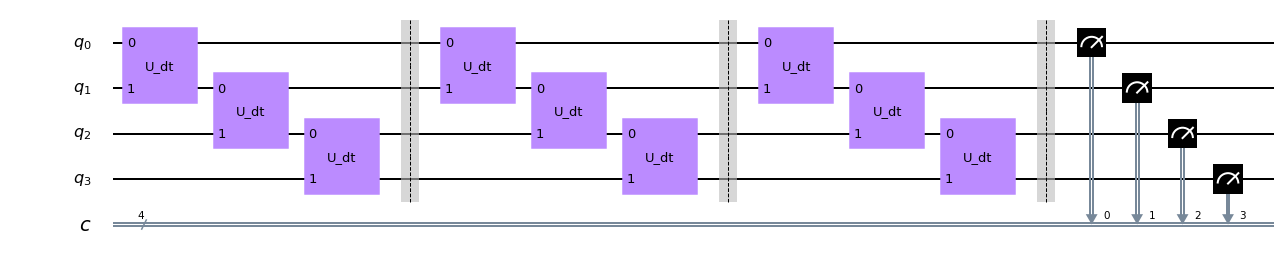

In [40]:
qc = QuantumCircuit(4,4) # My 4-qubit register (4 classical bits to store output)

qc.append(U_dt,[0,1])
qc.append(U_dt,[1,2])
qc.append(U_dt,[2,3])
qc.barrier()

qc.append(U_dt,[0,1])
qc.append(U_dt,[1,2])
qc.append(U_dt,[2,3])
qc.barrier()

qc.append(U_dt,[0,1])
qc.append(U_dt,[1,2])
qc.append(U_dt,[2,3])
qc.barrier()

qc.measure([0,1,2,3],[0,1,2,3]) # Measure all qubits in the computational basis (Sz)

qc.draw(output='mpl')

We copy code from https://qiskit-staging.mybluemix.net/documentation/terra/executing_quantum_programs.html, updated with the provider information from https://quantumcomputing.stackexchange.com/questions/9161, to choose a real quantum computer on which to run our circuit. The same page from the Qiskit documentation also gives code for running the job.

In [41]:
# The actual quantum computer
#from qiskit.providers.ibmq import least_busy

my_provider = IBMQ.get_provider()
#large_enough_devices = my_provider.backends(filters=lambda x: x.configuration().n_qubits > 4 and not x.configuration().simulator)
#backend = least_busy(large_enough_devices)
#print("The best backend is " + backend.name()) # automatically applied

# Instead, we'll stick to ibmq_rome, which has a much smaller CNOT error rate (which is meaningful here!)
# Testing ibmqx2 gave less than 25% of the output in state |0000> given input |0000> (expected: 100%)
backend = my_provider.get_backend('ibmq_rome') 
print(backend)

# The simulator: Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

ibmq_rome


In [42]:
from qiskit.tools.monitor import job_monitor
# Number of shots to run the program (experiment); maximum is 8192 shots.
shots = 1024
# Maximum number of credits to spend on executions.
max_credits = 3

job_exp = execute(qc, backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)

job_sim = execute(qc, backend_sim, shots=1024)

Job Status: job has successfully run


Finally, we obtain output from our job, plotted as a histogram; there are sixteen possible basis states $\{|0000\rangle, |0001\rangle, \cdots, |1111\rangle\}$, and we may observe the number of counts of each.

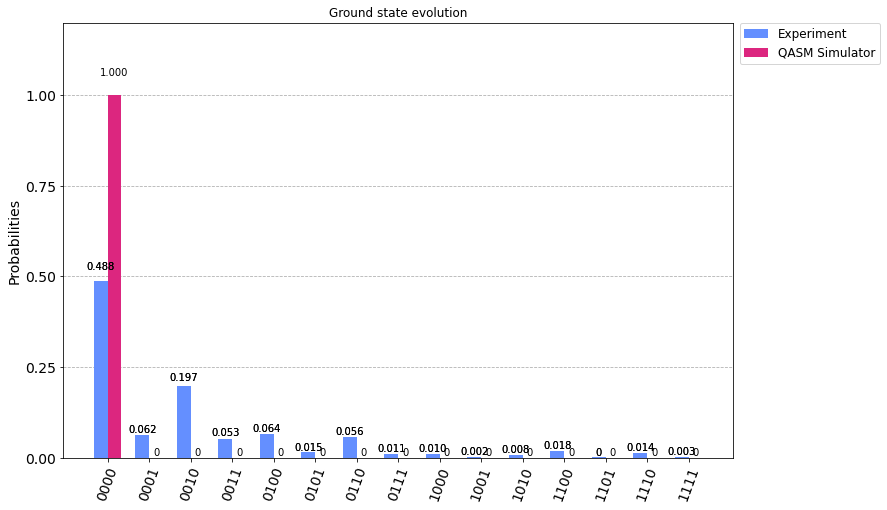

In [43]:
result = job_exp.result()
result_sim = job_sim.result()
counts_exp = result.get_counts(qc)
counts_sim = result_sim.get_counts(qc)
plot_histogram([counts_exp,counts_sim],figsize=[12,8], \
               legend=["Experiment","QASM Simulator"],title="Ground state evolution")

It is additionally straightforward to initialize different initial states and run the circuit on these. For instance, we can run our circuit on the uniform superposition state
$$\frac{1}{\sqrt{2^4}} \sum_{x \in \{0,1\}^4} |x\rangle$$
or in one of the singlet states $\{|0101\rangle, |1010\rangle\}$. This is given below. Note that we condense the time evolution operator into a large composite gate so that it may be appended to any initial state we like.

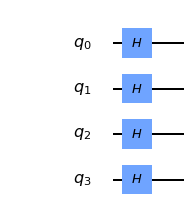

In [44]:
uniform = QuantumCircuit(4,name="unif")
uniform.h(0)
uniform.h(1)
uniform.h(2)
uniform.h(3)

unif = uniform.to_instruction()

uniform.draw()

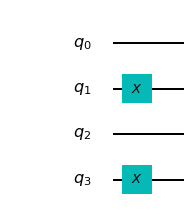

In [45]:
sing_one_circ = QuantumCircuit(4,name="sing_1")
sing_one_circ.x(1)
sing_one_circ.x(3)
sing_one = sing_one_circ.to_instruction()

sing_one_circ.draw()

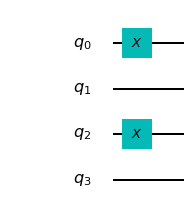

In [46]:
sing_two_circ = QuantumCircuit(4,name="sing_2")
sing_two_circ.x(0)
sing_two_circ.x(2)
sing_two = sing_two_circ.to_instruction()

sing_two_circ.draw()

In [47]:
time_evolve = QuantumCircuit(4,4,name="time_evol")
time_evolve.append(U_dt,[0,1])
time_evolve.append(U_dt,[1,2])
time_evolve.append(U_dt,[2,3])
time_evolve.barrier()

time_evolve.append(U_dt,[0,1])
time_evolve.append(U_dt,[1,2])
time_evolve.append(U_dt,[2,3])
time_evolve.barrier()

time_evolve.append(U_dt,[0,1])
time_evolve.append(U_dt,[1,2])
time_evolve.append(U_dt,[2,3])
time_evolve.barrier()

time_evolve.measure([0,1,2,3],[0,1,2,3])

evolve = time_evolve.to_instruction()

In [48]:
qc_unif = QuantumCircuit(4,4)
qc_unif.append(unif,[0,1,2,3])
qc_unif.append(evolve,[0,1,2,3],[0,1,2,3])

qc_sing_one = QuantumCircuit(4,4)
qc_sing_one.append(sing_one,[0,1,2,3])
qc_sing_one.append(evolve,[0,1,2,3],[0,1,2,3])

qc_sing_two = QuantumCircuit(4,4)
qc_sing_two.append(sing_two,[0,1,2,3])
qc_sing_two.append(evolve,[0,1,2,3],[0,1,2,3])

Job Status: job has successfully run


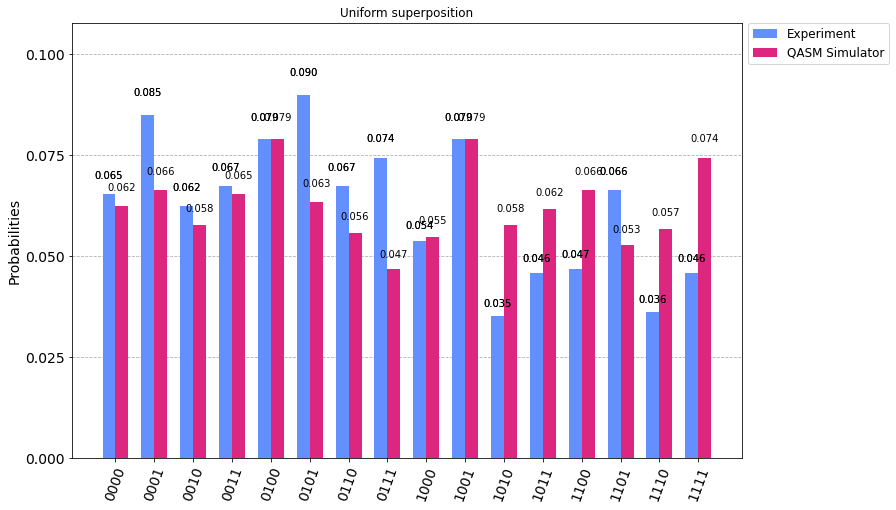

In [49]:
# Uniform superposition
job_unif = execute(qc_unif, backend, shots=shots, max_credits=max_credits)
sim_unif = execute(qc_unif, backend_sim, shots=1024)
job_monitor(job_unif)

res_unif = job_unif.result()
simres_unif = sim_unif.result()
ct_exp_unif = res_unif.get_counts(qc_unif)
ct_sim_unif = simres_unif.get_counts(qc_unif)

plot_histogram([ct_exp_unif,ct_sim_unif],figsize=[12,8], \
               legend=["Experiment","QASM Simulator"],title="Uniform superposition")

Job Status: job has successfully run


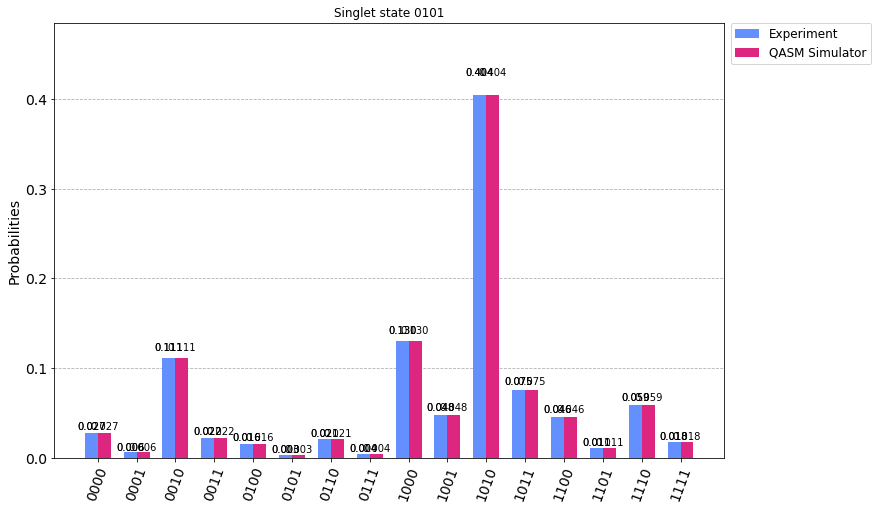

In [50]:
# Singlet state 0101
job_sing_one = execute(qc_sing_one, backend, shots=shots, max_credits=max_credits)
sim_sing_one = execute(qc_sing_one, backend_sim, shots=1024)
job_monitor(job_sing_one)

res_sing_one = job_sing_one.result()
simres_sing_one = job_sing_one.result()
ct_exp_sing_one = res_sing_one.get_counts(qc_sing_one)
ct_sim_sing_one = simres_sing_one.get_counts(qc_sing_one)

plot_histogram([ct_exp_sing_one,ct_sim_sing_one],figsize=[12,8], \
               legend=["Experiment","QASM Simulator"],title="Singlet state 0101")

Job Status: job has successfully run


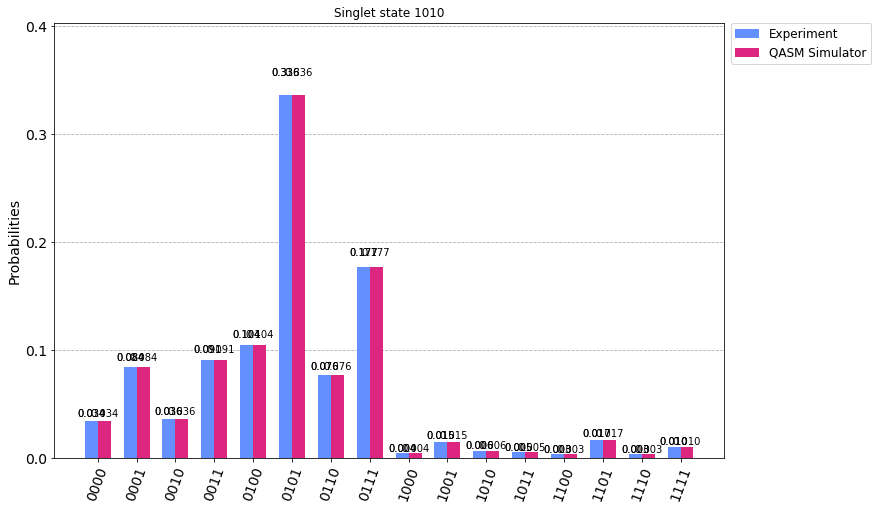

In [51]:
# Singlet state 1010
job_sing_two = execute(qc_sing_two, backend, shots=shots, max_credits=max_credits)
sim_sing_two = execute(qc_sing_two, backend_sim, shots=1024)
job_monitor(job_sing_two)

res_sing_two = job_sing_two.result()
simres_sing_two = job_sing_two.result()
ct_exp_sing_two = res_sing_two.get_counts(qc_sing_two)
ct_sim_sing_two = simres_sing_two.get_counts(qc_sing_two)

plot_histogram([ct_exp_sing_two,ct_sim_sing_two],figsize=[12,8], \
               legend=["Experiment","QASM Simulator"],title="Singlet state 1010")

Finally, we consider using the highly entangled cluster state, prepared with a "cascading CZ" method.

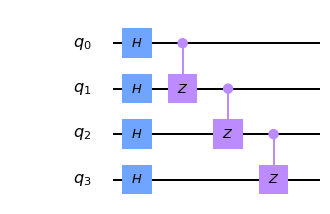

In [52]:
cluster_circ = QuantumCircuit(4,name="init_cluster")
cluster_circ.h(0)
cluster_circ.h(1)
cluster_circ.h(2)
cluster_circ.h(3)
cluster_circ.cz(0,1)
cluster_circ.cz(1,2)
cluster_circ.cz(2,3)

cluster = cluster_circ.to_instruction()

cluster_circ.draw()

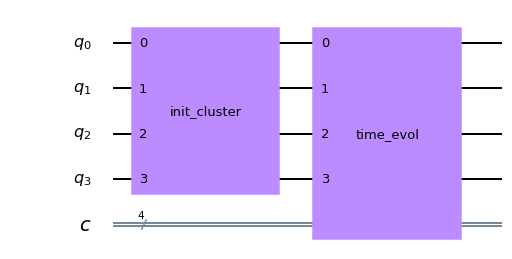

In [53]:
qc_cluster = QuantumCircuit(4,4)
qc_cluster.append(cluster,[0,1,2,3])
qc_cluster.append(evolve,[0,1,2,3],[0,1,2,3])

qc_cluster.draw()

Job Status: job has successfully run


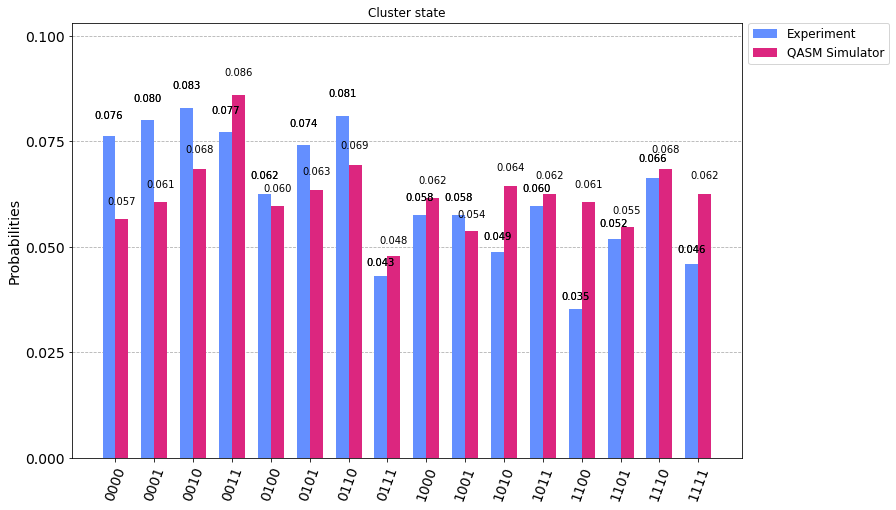

In [54]:
job_clust = execute(qc_cluster, backend, shots=shots, max_credits=max_credits)
sim_clust = execute(qc_cluster, backend_sim, shots=1024)
job_monitor(job_clust)

res_clust = job_clust.result()
simres_clust = sim_clust.result()
ct_exp_clust = res_clust.get_counts(qc_cluster)
ct_sim_clust = simres_clust.get_counts(qc_cluster)

plot_histogram([ct_exp_clust,ct_sim_clust],figsize=[12,8], \
               legend=["Experiment","QASM Simulator"],title="Cluster state")